In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
### Reading data in from the cluster ghpcc ...

chroms = !ssh ghpcc cat /home/sv49w/hg38.chroms | cut -f1 -d" " |cut -f2 -d">"

data = {}
for chrom in chroms:
    dat = !ssh ghpcc cat /home/sv49w/bbb/{chrom}.tsv
    data[chrom] = "\n".join(dat)

In [3]:
%matplotlib inline
# import ipywidgets as widgets
# %matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns

import numpy as np

from io import StringIO

In [7]:
#make sure data is defined globally at the very end of the notebook ...

def split_counts_fracs(counts):
    c_fracs = [_c for _c in counts if "frac_" in _c]
    c_counts = [_c for _c in counts if "frac_" not in _c]
    return c_fracs,c_counts

def parse_data(chrom):
    df = pd.read_csv(StringIO(data[chrom]),sep=" ")
    # let's parse "name" into cell-type, enzyme, crosslink etc
    #
    # first one: cis+trans = tot (mapped)
    assert (df[["cis","trans"]].sum(axis=1) == df["tot"]).all()
    # second sanity check : allM = cisM + transM + contigM
    assert (df[["cis_chrom","trans_chrom","contig_chrom"]].sum(axis=1) == df["all_chrom"]).all()

    # df["cis_perc"] = df["cis"]/df["tot"]
    # df["ct_chrom"] = df["cis_chrom"]+df["trans_chrom"]+df["contig_chrom"]
    df["frac_tc"] = df["trans_chrom"]/df["cis_chrom"]
    df["frac_ta"] = df["trans_chrom"]/df["all_chrom"]
    return df.rename({"cross":"crosslink"})


def parse_u54_names(name_split):
    exptype = name_split[0]
    celltype = name_split[1]
    if (exptype == "ENCODE")and(celltype=="HeLa"):
        cross = "FA"
        enzyme = name_split[2]
        cycle = "NS"        
    elif (exptype == "U54")and(celltype == "HFFc6"):
        if name_split[2] in ["p17","p22"]:
            cross = name_split[3]
            enzyme = name_split[4]
        else:
            cross = name_split[2]
            enzyme = name_split[3]
        cycle = "NS"
    elif (exptype == "U54")and(celltype in ["END4DN", "H1ESC4DN", "HFFc64DN"]):
        cross = name_split[3]
        enzyme = name_split[4]
        cycle = "NS"        
    elif celltype in ["END","ESC","END4DN","ESC4DN","H1ESC4DN","ENDMaehr","hEND4DN","PFE"]:
        cross = name_split[2]
        enzyme = name_split[3]
        cycle = "NS"
    elif celltype in "HFF":
        cross = name_split[3]
        enzyme = name_split[4]
        cycle = "NS"
    elif celltype == "HelaS3":
        cross = name_split[3]
        enzyme = name_split[4]
        cycle = name_split[2]
    else:
        print("I'm something else - dela with me...")
        print(name_split)
        ret = {}
    if enzyme == "HindIIII":
        enzyme = "HindIII"
    if enzyme not in ['DdeI','DpnII','HindIII','MNase']:
        print("enzyme",enzyme,name_split)
    if cross not in ['DSG','EGS','FA']:
        print("cross",cross,name_split)
    if cycle not in ['NS','G1','M']:
        print("cycle",cycle,name_split)
    ret = {"cell":celltype, "cycle": cycle, "cross": cross, "enzyme": enzyme}
    return pd.Series(ret).rename({"cross":"crosslink"})

# this should be the same for all of them, but it's ugly this way ...
cell_cycle_cross_enzyme = parse_data("chrM")["name"].str.split("-").apply(parse_u54_names)

enzyme NcoI ['U54', 'END', 'FA', 'NcoI', '20161014', 'R1', 'T1']
enzyme NcoI ['U54', 'ESC', 'FA', 'NcoI', '20161018', 'R1', 'T1']
enzyme MboI ['U54', 'HFF', 'beads', 'DSG', 'MboI', '20161219', 'R1', 'T1']
enzyme MboI ['U54', 'HFF', 'beads', 'DSG', 'MboI', '20161219', 'R1', 'T2']
enzyme NcoI ['U54', 'HFF', 'beads', 'DSG', 'NcoI', '20161014', 'R1', 'T1']
enzyme MboI ['U54', 'HFF', 'beads', 'EGS', 'MboI', '20161219', 'R1', 'T1']
enzyme NcoI ['U54', 'HFF', 'beads', 'EGS', 'NcoI', '20161014', 'R1', 'T1']
enzyme MboI ['U54', 'HFF', 'beads', 'FA', 'MboI', '20161219', 'R1', 'T1']
enzyme MflI ['U54', 'HFF', 'beads', 'FA', 'MflI', '20160930', 'R1', 'T1']
enzyme NcoI ['U54', 'HFF', 'beads', 'FA', 'NcoI', '20161014', 'R1', 'T1']
enzyme NheI ['U54', 'HFF', 'beads', 'FA', 'NheI', '20160930', 'R1', 'T1']
enzyme MflI ['U54', 'HFF', 'plate', 'DSG', 'MflI', '20160615', 'R1', 'T1']
enzyme MflI ['U54', 'HFF', 'plate', 'FA', 'MflI', '20160615', 'R1', 'T1']
enzyme NheI ['U54', 'HFF', 'plate', 'FA', 'NheI', 

In [8]:
for c in cell_cycle_cross_enzyme.columns:
    print(c,cell_cycle_cross_enzyme[c].unique())

cell ['END' 'ESC' 'HelaS3' 'HFF' 'PFE' 'HeLa' 'END4DN' 'ENDMaehr' 'ESC4DN'
 'H1ESC4DN' 'hEND4DN' 'HFFc64DN' 'HFFc6']
cycle ['NS' 'G1' 'M']
crosslink ['DSG' 'EGS' 'FA']
enzyme ['DdeI' 'DpnII' 'HindIII' 'MNase' 'NcoI' 'MboI' 'MflI' 'NheI' 'PspXI'
 'SgrAI' 'SgrDI']


In [9]:
import seaborn as sns
# sns.set(style="whitegrid")
sns.set()
sns.set_context("paper")
# sns.set_palette("colorblind")



In [20]:
sns.stripplot?

cell ['END' 'ESC' 'HelaS3' 'HFF' 'PFE' 'HeLa' 'END4DN' 'ENDMaehr' 'ESC4DN'
 'H1ESC4DN' 'hEND4DN' 'HFFc64DN' 'HFFc6']
cycle ['NS' 'G1' 'M']
crosslink ['DSG' 'EGS' 'FA']
enzyme ['DdeI' 'DpnII' 'HindIII' 'MNase' 'NcoI' 'MboI' 'MflI' 'NheI' 'PspXI'
 'SgrAI' 'SgrDI']


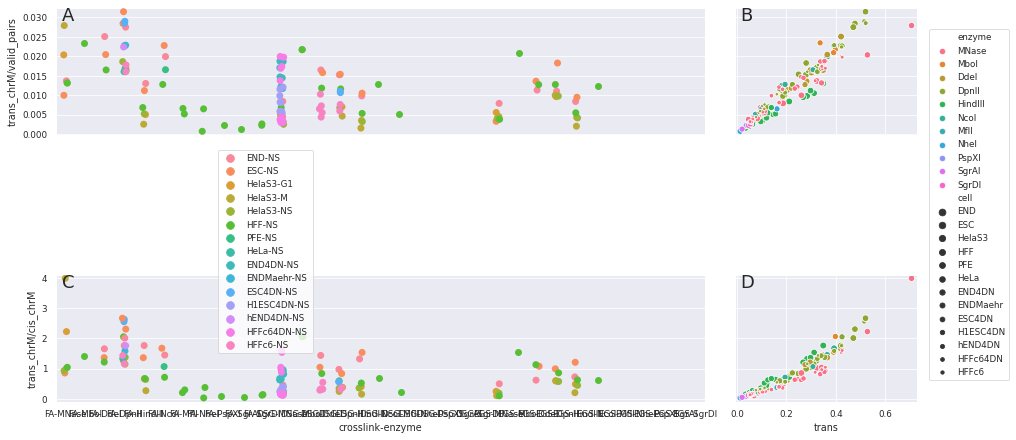

In [44]:
# errors = ddf.groupby(("cross","enzyme","cell")).std()
# means.plot.bar(yerr=errors, ax=ax, capsize=4,logy=True)

fig1 = plt.figure(figsize=(14,6),constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3,nrows=2,figure=fig1,height_ratios=[1,1], width_ratios=[5,1.4,0.2])
# # Also make sure the margins and spacing are apropriate
# spec1.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)
# # BUT: this is irrelevant for the saved image, if using bbox_inches='tight'in savefig !
ax1 = fig1.add_subplot(spec1[0,0])
ax2 = fig1.add_subplot(spec1[1,0])

ax1s = fig1.add_subplot(spec1[0,1])
ax2s = fig1.add_subplot(spec1[1,1])
# ,sharey=ax1
# ,sharey=ax2

axl = fig1.add_subplot(spec1[:,2])


chrom = "chr19"
counts = ["cis_chrom","trans_chrom","cis","trans","frac_tc"]
# counts = ["cis","trans"]
# enzymes = ['DdeI','DpnII','HindIII','MNase']
enzymes = ['DdeI' ,'DpnII' ,'HindIII' ,'MNase' ,'NcoI' ,'MboI' ,'MflI' ,'NheI' ,'PspXI','SgrAI','SgrDI']
size_order = ['MNase' ,'MboI' ,'DdeI' ,'DpnII' ,'HindIII' ,'NcoI' ,'MflI' ,'NheI' ,'PspXI','SgrAI','SgrDI']
cells = ['END','ESC','HelaS3','HFF','PFE','HeLa','END4DN','ENDMaehr','ESC4DN','H1ESC4DN','hEND4DN','HFFc64DN','HFFc6']
# cells = ['END','ESC','HelaS3','HFF','END4DN','ESC4DN','H1ESC4DN','HFFc64DN']
# cells = ['END','ESC','HelaS3','HFF','HeLa','END4DN','ENDMaehr','ESC4DN','H1ESC4DN','hEND4DN','HFFc64DN','HFFc6']
# cells = ['END','ESC','HelaS3','HFF']
# cells = ['HFF','HFFc6','HelaS3']
cycle = ['NS','G1','M']
cross = ['DSG','EGS','FA']
# cross = ['FA']
normalized = True
order=['FA-MNase','FA-MboI','FA-DdeI','FA-DpnII','FA-HindIII','FA-NcoI','FA-MflI','FA-NheI','FA-PspXI','FA-SgrAI','FA-SgrDI']
order+=['DSG-MNase','DSG-MboI','DSG-DdeI','DSG-DpnII','DSG-HindIII','DSG-NcoI','DSG-MflI','DSG-NheI','DSG-PspXI','DSG-SgrAI','DSG-SgrDI']
order+=['EGS-MNase','EGS-MboI','EGS-DdeI','EGS-DpnII','EGS-HindIII','EGS-NcoI','EGS-MflI','EGS-NheI','EGS-PspXI','EGS-SgrAI','EGS-SgrDI']
# grp = "cross_enzyme_cell_cycle".split("_")
grp = "crosslink-enzyme_cell-cycle".split("_")
log=False

# this is just to make us able to change chroms
df = parse_data(chrom)

c1 = cell_cycle_cross_enzyme["enzyme"].isin(enzymes)
c2 = cell_cycle_cross_enzyme["cell"].isin(cells)
c3 = cell_cycle_cross_enzyme["cycle"].isin(cycle)
c4 = cell_cycle_cross_enzyme["crosslink"].isin(cross)

ccce = cell_cycle_cross_enzyme[c1&c2&c3&c4]

if normalized:
    c_fracs,c_counts = split_counts_fracs(counts)
    df_norm = df[c_counts]/df[["tot"]].values
    loc_df = pd.merge(df_norm,ccce,left_index=True,right_index=True)
    loc_df = pd.merge(loc_df,df[c_fracs],left_index=True,right_index=True)
else:
    df_norm = df[counts]
    loc_df = pd.merge(df_norm,ccce,left_index=True,right_index=True)

loc_df["cell-cycle"] = loc_df[["cell","cycle"]].apply(lambda x: "-".join(x),axis=1)
loc_df["crosslink-enzyme"] = loc_df[["crosslink","enzyme"]].apply(lambda x: "-".join(x),axis=1)
    
# mmeans = loc_df.groupby(grp).max()
# mmeans = loc_df.set_index(grp)
# groupby(grp).mean()

for c in cell_cycle_cross_enzyme.columns:
    print(c,loc_df[c].unique())

# sns.despine(left=True, bottom=True)

hue_order=["ESC-NS","END-NS","HFF-NS","HelaS3-NS","HelaS3-G1","HelaS3-M"]
# mmeans[["cis_chrom","trans_chrom"]].plot(kind="bar",stacked=True, ax=ax1, capsize=4,logy=log)
sns.stripplot(hue="cell-cycle", y='trans_chrom', x="crosslink-enzyme",order=order,
              size=7, data=loc_df, ax=ax1);
# sns.barplot(x="p1_flavor", y='liked', hue='p2_flavor', data=data, ci=None, ax=ax[2]);
ax1.set_ylabel("trans_chrM/valid_pairs")
ax1.grid(False,axis="x")
ax1.get_legend().set_visible(False)
ax1.text(0.01, 0.9,'A', fontsize=18, transform=ax1.transAxes)

sns.stripplot(hue="cell-cycle", y='frac_tc', x="crosslink-enzyme",order=order,
               size=7, data=loc_df, ax=ax2);
# mmeans[["frac_tc"]].plot(kind="bar",stacked=False, ax=ax2, capsize=4,logy=log,legend=False)
ax2.set_ylabel("trans_chrM/cis_chrM")
ax2.grid(False,axis="x")
# ax2.get_legend().set_visible(False)
ax2.text(0.01, 0.9,'C', fontsize=18, transform=ax2.transAxes)

ax2.legend(bbox_to_anchor=(.25, 0.38), loc='lower left', borderaxespad=0.,shadow=False,facecolor="white")


# axltwin = axl.twinx()
# hh,ll=ax1.get_legend_handles_labels() # get labels and handles from ax1
# axltwin.legend(hh,ll,bbox_to_anchor=(.0, 0.66), loc='center left', borderaxespad=0.)
# axltwin.axes.xaxis.set_ticks([])
# axltwin.axes.yaxis.set_ticks([])
# axltwin.axes.xaxis.set_ticklabels([])
# axltwin.axes.yaxis.set_ticklabels([])
# ax1.get_legend().remove()


sizes = [80,40,30]
# sizes=sizes

x = "trans"
# sns.scatterplot(x=x,y="trans_chrom",hue="cell",size="enzyme",#hue_order=size_order,
#                 data=loc_df, ax=ax1s, legend="brief")

# sns.scatterplot(x=x,y="frac_tc",hue="cell",size="enzyme",#hue_order=size_order,
#                 data=loc_df, ax=ax2s, legend=False)
sns.scatterplot(x=x,y="trans_chrom",hue="enzyme",size="cell",hue_order=size_order,
                data=loc_df, ax=ax1s, legend="brief")

sns.scatterplot(x=x,y="frac_tc",hue="enzyme",size="cell",hue_order=size_order,
                data=loc_df, ax=ax2s, legend=False)

ax1s.text(0.03, 0.9,'B', fontsize=18, transform=ax1s.transAxes)
ax2s.text(0.03, 0.9,'D', fontsize=18, transform=ax2s.transAxes)

# # # Place a legend to the right of this smaller subplot.
# # aaa.legend(bbox_to_anchor=(1.05, -0.1), loc='lower left', borderaxespad=-0.2)
# print(ax1.get_yticklabels())


xtl = ax2.xaxis.get_ticklabels()

ax1s.axes.yaxis.set_ticklabels([])
ax1s.set_ylabel("")

ax2s.axes.yaxis.set_ticklabels([])
ax2s.set_ylabel("")

ax1s.axes.xaxis.set_ticklabels([])
ax1s.set_xlabel("")

ax1.axes.xaxis.set_ticklabels([])
ax1.set_xlabel("")

ax2.axes.xaxis.set_ticklabels(xtl)


# ax1s.axes.yaxis.set_visible(False)
# ax2s.axes.yaxis.set_visible(False)




hh,ll=ax1s.get_legend_handles_labels() # get labels and handles from ax1s
# axl.clear()
axl.legend(hh,ll,bbox_to_anchor=(.0, 0.5), loc='center left', borderaxespad=0.,facecolor="white")
axl.axes.xaxis.set_ticklabels([])
axl.axes.yaxis.set_ticklabels([])
axl.axes.xaxis.set_ticks([])
axl.axes.yaxis.set_ticks([])
axl.set_facecolor("white")
axl.grid(False)

ax1s.get_legend().remove()
# ax.legend().set_visible(False)
# axl.set_visible(False)

y="trans_chrom"
x_span = loc_df[x].max() - loc_df[x].min()
y_span = loc_df[y].max() - loc_df[y].min()
dx = 0.03*x_span
dy = 0.03*y_span
ax1s.set_xlim((loc_df[x].min()-dx,loc_df[x].max()+dx))
ax1s.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))
ax1.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))


# # if log:
# #     ax2.set_xlim((loc_df[x].min()*0.9,loc_df[x].max()*1.01))
# #     ax2.set_ylim((loc_df[y].min()*0.9,loc_df[y].max()*1.01))
# #     sp.set(xscale="log")
# #     sp.set(yscale="log")
# # else:
#     ax2.set_xlim((loc_df[x].min()-dx,loc_df[x].max()+dx))
#     ax2.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))

y="frac_tc"
x_span = loc_df[x].max() - loc_df[x].min()
y_span = loc_df[y].max() - loc_df[y].min()
dx = 0.03*x_span
dy = 0.03*y_span
ax2s.set_xlim((loc_df[x].min()-dx,loc_df[x].max()+dx))
ax2s.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))
ax2.set_ylim((loc_df[y].min()-dy,loc_df[y].max()+dy))

# plt.text(0.5, 0.5, 'matplotlib', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)


# print(ax1.get_position())
# print(ax2.get_position())
# print(ax1s.get_position())
# print(ax2s.get_position())
# print(axl.get_position())
plt.savefig("other_stuff.pdf")


In [ ]:
x0=0.125, y0=0.5368181818181819, x1=0.643048128342246, y1=0.88
x0=0.125, y0=0.1250000000000001, x1=0.643048128342246, y1=0.46818181818181825
x0=0.6886363636363637, y0=0.5368181818181819, x1=0.8336898395721926, y1=0.88
x0=0.6886363636363637, y0=0.1250000000000001, x1=0.8336898395721926, y1=0.46818181818181825
x0=0.8792780748663103, y0=0.1250000000000001, x1=0.9000000000000001, y1=0.88

In [238]:
ax1.set_position([left, bottom, width, height])

In [33]:
sns.scatterplot?

size_order = []

In [ ]:
order=['FA-MNase','FA-MboI','FA-DdeI','FA-DpnII','FA-HindIII','FA-NcoI','FA-MflI','FA-NheI','FA-PspXI','FA-SgrAI','FA-SgrDI']